In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
from PIL import Image
from IPython.display import clear_output

In [ ]:
# Function to show an image
def showarray(img):
    img = np.uint8(np.clip(img, 0, 255))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Load image as numpy array
def load_image(filename):
    img = Image.open(filename).convert('RGB')
    img = np.float32(img)
    return img

def preprocess(img):
    img = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).float().to(device)
    return img

def deprocess(img_tensor):
    img = img_tensor.squeeze(0).permute(1,2,0).detach().cpu().numpy()
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img



In [65]:
# Use VGG19
model = models.vgg19(pretrained=True).features
model.eval()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Choose a layer
dream_layer_idx = 28
dream_layer = model[dream_layer_idx] 


In [66]:
# L2 objective
def objective_L2(activations):
    return activations.norm()

# Guided dreaming objective
guide_features = None  # Global

def objective_guide(activations):
    B, C, H, W = activations.shape
    activations = activations.view(C, -1)
    guide = guide_features.view(C, -1)
    A = torch.mm(activations.t(), guide)
    idx = A.argmax(1)
    return torch.sum(activations[torch.arange(activations.size(0)), idx])


In [67]:
def make_step(img, model, step_size=1.5, jitter=32, objective=objective_L2):
    img = img.clone().detach().requires_grad_(True)

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    img = torch.roll(img, shifts=ox, dims=2)
    img = torch.roll(img, shifts=oy, dims=3)

    img.retain_grad()
    model.zero_grad()

    x = img
    for i, layer in enumerate(model):
        x = layer(x)
        if i == dream_layer_idx:  # You must find the correct idx for dream_layer
            break

    loss = objective(x)
    loss.backward()

    grad = img.grad
    grad /= grad.abs().mean() + 1e-8  # Caffe style normalization
    img = img + grad * step_size

    img = torch.roll(img, shifts=-ox, dims=2)
    img = torch.roll(img, shifts=-oy, dims=3)

    img = torch.clamp(img, 0, 255)

    return img.detach()


In [68]:
def deepdream(img, model, iter_n=10, octave_n=4, octave_scale=1.4, step_size=0.01, objective=objective_L2):
    # Create octaves
    octaves = [img]
    for _ in range(octave_n - 1):
        hw = [int(dim / octave_scale) for dim in octaves[-1].shape[:2]]
        small = np.array(Image.fromarray(np.uint8(octaves[-1])).resize((hw[1], hw[0]), Image.LANCZOS))
        octaves.append(np.float32(small))
        
    detail = np.zeros_like(octaves[-1])

    for octave, octave_base in enumerate(reversed(octaves)):
        h, w = octave_base.shape[:2]
        
        if octave > 0:
            detail = np.array(Image.fromarray(np.uint8(detail)).resize((w, h), Image.LANCZOS)).astype(np.float32)

        # Prepare input
        base_img = torch.from_numpy(octave_base).permute(2, 0, 1).unsqueeze(0).to(device)
        detail_t = torch.from_numpy(detail).permute(2, 0, 1).unsqueeze(0).to(device)

        base_img = base_img + detail_t

        for i in range(iter_n):
            base_img = make_step(base_img, model, step_size=step_size, objective=objective)

            vis = deprocess(base_img)
            showarray(vis)
            print(f"Octave {octave}, Iteration {i}")
            clear_output(wait=True)

        detail = deprocess(base_img) - octave_base

    return deprocess(base_img)


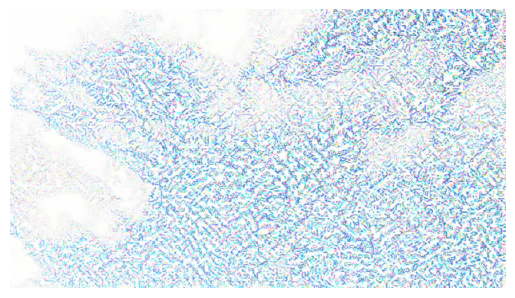

In [69]:
img = load_image('./img/sky1024px.jpg')
dreamed_image = deepdream(img, model, iter_n=20, octave_n=4, octave_scale=1.4, step_size=0.01, objective=objective_L2)
showarray(dreamed_image)


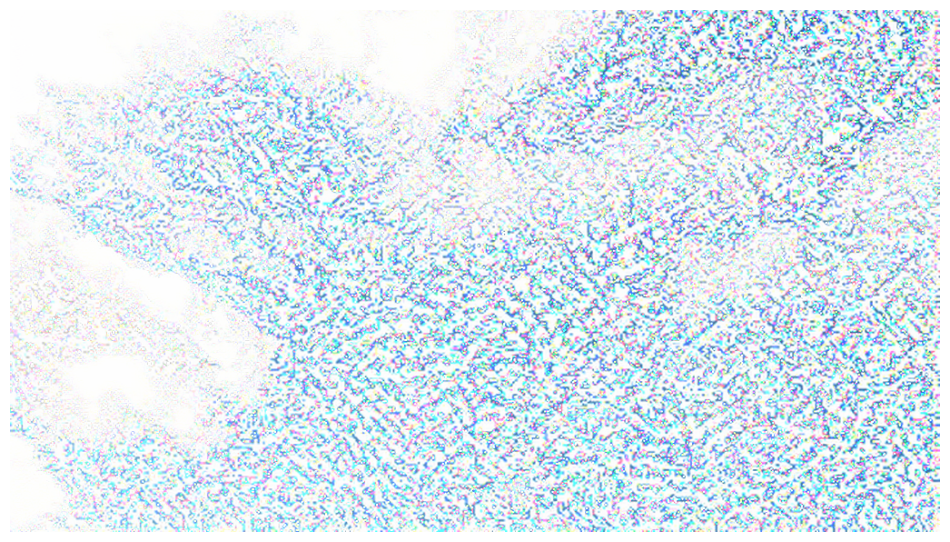

In [70]:
plt.figure(figsize=(12, 12))  # width x height in inches
plt.imshow(dreamed_image)
plt.axis('off')
plt.show()